## Neural network for dielectric constant prediction of AFM images
### June 2024 - Code by Mauricio Cano Galván
This code takes a percentage of image simulation data and predicts the rest of the image's dielectric constant

Library Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import copy

from sklearn.metrics import r2_score, mean_absolute_error
from matplotlib import colormaps
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from scipy.stats import norm
import seaborn as sns
import math
from nn_backend.import_xyz_img import import_xyz_img
from nn_backend.conv_imgs import conv_imgs
from nn_backend.data_import import import_curves_from_folder, curve_calibration, matrix_cut, data_augment, mask_from_topo
from nn_backend.nn_for_ep import nn_for_ep
from nn_backend.post_process import img_export, histogram_export
from skimage.metrics import structural_similarity as ssim


viridis = colormaps['viridis']
newcolors = viridis(np.linspace(0, 1, 256))
black = np.array([0, 0, 0, 1])
newcolors[0:33, :] = black
newcmp = ListedColormap(newcolors)
del black, newcolors, viridis

In [2]:
#Program configuration

#Data import
name='efm9' #Filename with which to save exports
curves_file=rf'c:\Users\mcano\Code\rawdata\preprocessed curves\efm9_curves_calibrated.npy'
topography_file=rf'c:\Users\mcano\Code\rawdata\img_data\EFM9\TopographyEFM9_nm.txt'
ref_file=rf"c:\Users\mcano\Code\rawdata\img_data\EFM9\efm9_ep_map_corrected.txt"
raw_curves_folder=0
calibrate_curves=1
nu_dim=118 #Dimensions of the final εp map
ref_flip=1
topo_flip=0

#Curve pre-processing
curves_max_limit=1000 #Maximum height [nm] to which the approximation curves will be projected
curve_nsamples=12 #Number of samples to take from approximation curves
curve_height_setpoint=20 #First curve height [nm] to take in consideration for sampling

#Optional graphics to show in notebook (1 to show images, 0 to hide)
input_imgs_view=1

#Neural Network Setup
pctg=3.5 #Percentage of train data
cutout_size=9 #Size of the topography cutouts for the convolution operation
kernel_dim=3 #Kernel dimension for the convolution operation
iterations=300
batch_sz=200 #Batch size for training


#Mask configuration. The following images should be processed using the values established.

    #EFM9: binary_threshold=0.04, object_size=3, hole_size=30, m_thresh=0.30
    #EFM8: binary_threshold=0.41, object_size=3, hole_size=30, m_thresh=0.77
    #EFM7: binary_threshold=0.095, object_size=4, hole_size=15, m_thresh=0.44
    #EFVM: binary_threshold=0.05, object_size=2, hole_size=2, m_thresh=0.785

binary_threshold=0.04 #Threshold for the topography image flood
object_size=3 #Maximum object size that should be eliminated as noise
hole_size=30 #Maximum hole size that should be filled in the mask
m_ep_thresh=0.30 #Threshold for the simulation image flood

Data Import

In [3]:
#Curve import
if not raw_curves_folder:
    curves_projected=pd.DataFrame(np.load(rf'{curves_file}'))
    curves_projected=curves_projected.interpolate(axis=1)
    curves_projected=curves_projected.bfill(axis=1)
else:
    curves_projected, m_vec=import_curves_from_folder(curves_file)

    if calibrate_curves:
        K=0.718
        G=200
        uac=3
        curves_projected=curve_calibration(curves_projected, m_vec, K, G, uac)



In [4]:
#curves_name=rf'efm9_curves_calibrated'
#np.save('{curves_name}.npy', curves_projected)

In [5]:
#------Import the label data (εp map), as a matrix first and then transformed into a DataFrame.------#
#----------The data is then cleaned to remove outliers
y_mat, ax_ep, ay_ep= import_xyz_img(ref_file)
if ref_flip:
    y_mat=np.flipud(y_mat)
y_mat=matrix_cut(y_mat,nu_dim)
y=pd.DataFrame(np.reshape(y_mat,nu_dim**2))
#------Manual noise removal in label *ONLY FOR EFM9*------#

#Logarithmic sampling
maxlen=1713


zs=np.round((np.logspace(start=0,stop=math.log10(maxlen),num=curve_nsamples,endpoint=False)+curve_height_setpoint)).astype(int)
samples = []
[samples.append(x) for x in zs if x not in samples]


#New curves
curves=(np.array(curves_projected)).reshape(128,128,len(curves_projected.iloc[0,:]))
curves=matrix_cut(curves, nu_dim)
curves_sampled=curves[:,:,samples]

#Topography import
T_mat, x, y2 = import_xyz_img(topography_file)
if topo_flip:
    T_mat=np.flipud(T_mat)
T_mat=matrix_cut(T_mat, nu_dim)
T_mat=np.expand_dims(T_mat, axis=2)
T=T_mat.reshape(nu_dim**2)
#Put together training dataset
X_mat=np.concatenate((T_mat, curves_sampled), axis=2)

aa=["Z = "+str(x)+" nm" for x in samples]
inputs=["Topography"]
inputs=np.append(inputs, aa)

X=np.reshape(X_mat,(nu_dim**2,len(X_mat[0,0,:])))
X=pd.DataFrame(X, columns=inputs)


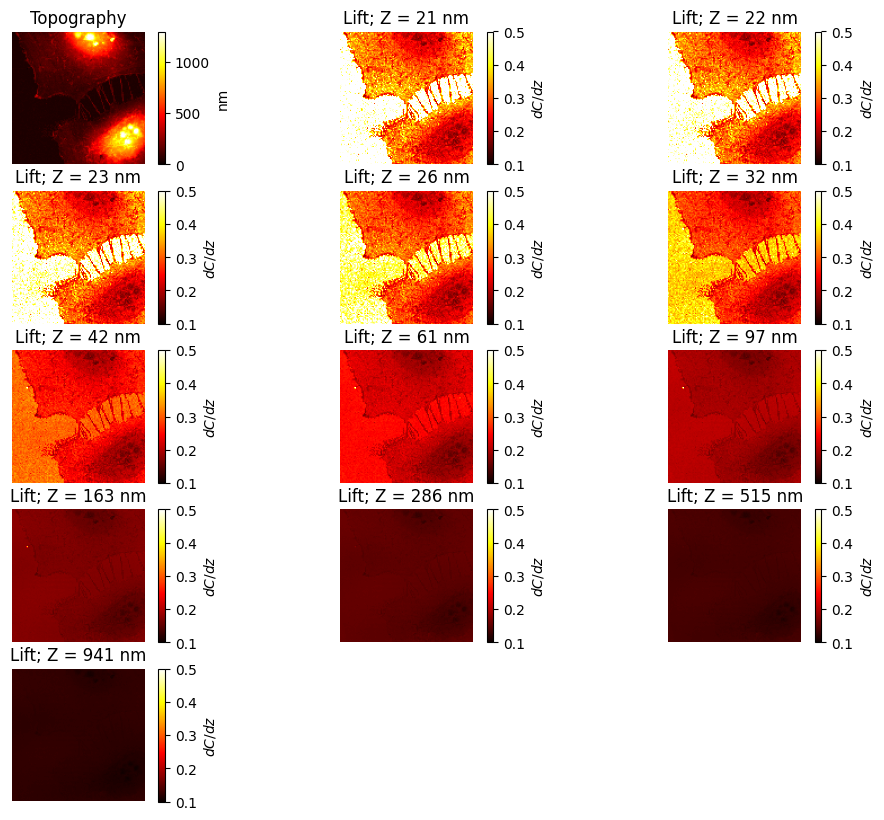

In [6]:
if input_imgs_view:
    fig=plt.figure(figsize=(12,10))
    ax=fig.add_subplot(5,3,1)
    pcm=ax.imshow(X_mat[:,:,0], cmap='hot')
    ax.set_title("Topography")
    plt.colorbar(pcm, label="nm")
    ax.axis('off')
    for i in range(2,14):
        ax=fig.add_subplot(5,3,i)
        pcm=ax.imshow(X_mat[:,:,i-1], cmap='hot', vmin=0.1, vmax=0.5)
        h=samples[i-2]
        ax.set_title("Lift; Z = "+str(h)+" nm")
        plt.colorbar(pcm, label="$dC/dz$")
        ax.axis('off')
     

Data Pre-Processing

C:\Users\mcano\AppData\Local\Temp\ipykernel_9152\2408753685.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  th=float(mask_ep.quantile(m_ep_thresh))


Text(0.5, 1.0, 'Final Train Mask')

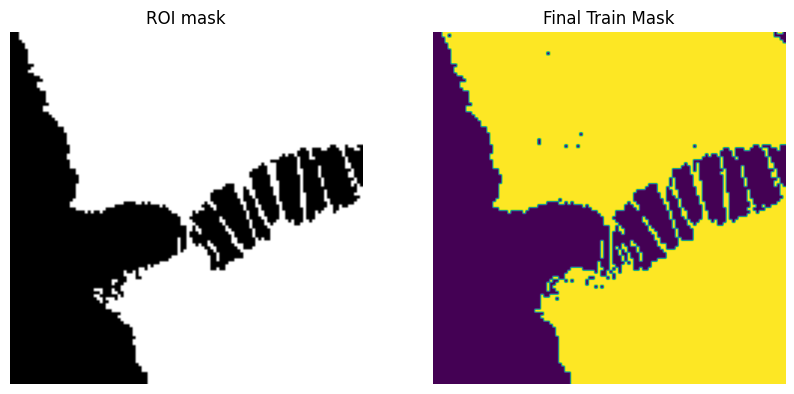

In [7]:
bin=mask_from_topo(T,binary_threshold,object_size,hole_size)

cell=bin.reshape(nu_dim**2,1)
roi_index=pd.DataFrame(copy(cell))
roi_index=roi_index.index[(roi_index[0])]


mask_ep=pd.DataFrame(copy(y))
th=float(mask_ep.quantile(m_ep_thresh))

mask_ep[(mask_ep[0]<=th)]=0
mask_ep[(mask_ep[0]!=0)]=1
mask_ep=cell*mask_ep
mask_ep_im=np.reshape(np.array(mask_ep), ((nu_dim),(nu_dim)))

cell_index=mask_ep.index[mask_ep[0]>0].tolist()


fig=plt.figure(figsize=(10,7))
ax=fig.add_subplot(1,2,1)
ax.imshow(bin, cmap='gray')
ax.set_title('ROI mask')
ax.axis('off')
ax=fig.add_subplot(1,2,2)
ax.imshow(mask_ep_im)
ax.axis('off')
ax.set_title('Final Train Mask')


In [8]:
#------Cell separation------#
y_cell=pd.DataFrame(y.iloc[cell_index])
X_cell=pd.DataFrame(X.iloc[cell_index])
y_roi=pd.DataFrame(y.iloc[roi_index])
X_roi=pd.DataFrame(X.iloc[roi_index])


#------Data Normalization------#
curve_scale=StandardScaler()
curve_scale.fit(X_cell)
Xn_cell=pd.DataFrame(curve_scale.transform(X_cell), columns=inputs)
Xn_roi=pd.DataFrame(curve_scale.transform(X_roi), columns=inputs)

In [9]:

#------Data Normalization------#
curve_scale=StandardScaler()
curve_scale.fit(X_cell)
Xn_cell=pd.DataFrame(curve_scale.transform(X_cell), columns=inputs)

In [10]:

topo_mat, x, y2 = import_xyz_img(topography_file)
if topo_flip:
    topo_mat=np.flipud(topo_mat)
topo=topo_mat.reshape(len(topo_mat)**2,1)

topo_scale=StandardScaler()
topo_scale.fit(topo)
topo_n=topo_scale.transform(topo)
topo_n_mat=topo_n.reshape(len(topo_mat),len(topo_mat),1)

Cv_mat=conv_imgs(topo_n_mat[:,:,0], cutout_size)
Cv_mat=Cv_mat.reshape(int(math.sqrt(len(Cv_mat))),int(math.sqrt(len(Cv_mat))),cutout_size,cutout_size)
Cv_mat=matrix_cut(Cv_mat, nu_dim)
Cv_mat=Cv_mat.reshape(nu_dim*nu_dim,cutout_size,cutout_size)
Cv_mat=np.expand_dims(Cv_mat, axis=-1)



Cv_cell_mat=Cv_mat[cell_index,:,:,:]
Cv_roi_mat=Cv_mat[roi_index,:,:,:]


100%|██████████| 120/120 [00:23<00:00,  5.05it/s]


Test-Train Separation

In [11]:

sss = ShuffleSplit(n_splits=1, test_size=1-(pctg/100), random_state=1)
sss.get_n_splits(Xn_cell, y_cell)
train_index, test_index = next(sss.split(Xn_cell, y_cell))
train_index=np.sort(train_index)  
test_index=np.sort(test_index)  



X_train, X_test = Xn_cell.iloc[train_index], Xn_cell.iloc[test_index] 
y_train, y_test = y_cell.iloc[train_index], y_cell.iloc[test_index]

Cv_train, Cv_test = Cv_cell_mat[train_index,:,:], Cv_cell_mat[test_index,:,:] 
Cv_train_aug=data_augment(Cv_train)


N_aug=int(len(Cv_train_aug[:,0,0,0])/len(Cv_train[:,0,0,0]))

X_train_aug=copy(X_train)
y_train_aug=copy(y_train)
for i in np.arange(N_aug-1):
    X_train_aug=pd.DataFrame(np.concatenate((X_train_aug, X_train), axis=0))
    y_train_aug=pd.DataFrame(np.concatenate((y_train_aug, y_train), axis=0))

Network Architecture

In [12]:
#------Example Keras Network------#
reg, histo=nn_for_ep(X_train_aug,Cv_train_aug,y_train_aug,X_test,Cv_test,y_test, verb=0)

Results

In [13]:
res=reg.predict([Xn_roi, Cv_roi_mat])

293/293 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Results visualization

C:\Users\mcano\AppData\Local\Temp\ipykernel_9152\1932549888.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  full_vec_roi[roi_index[i]]=res[i]
C:\Users\mcano\AppData\Local\Temp\ipykernel_9152\1932549888.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  full_vec_roi[i]=y.iloc[i]
C:\Users\mcano\AppData\Local\Temp\ipykernel_9152\1932549888.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  full_vec_cell[cell_index[i]]=res_cell[i]


0.9419
The error map presents 120 error values > 1 (1.31%)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'Resultado de red neuronal (train data=3.5%)')

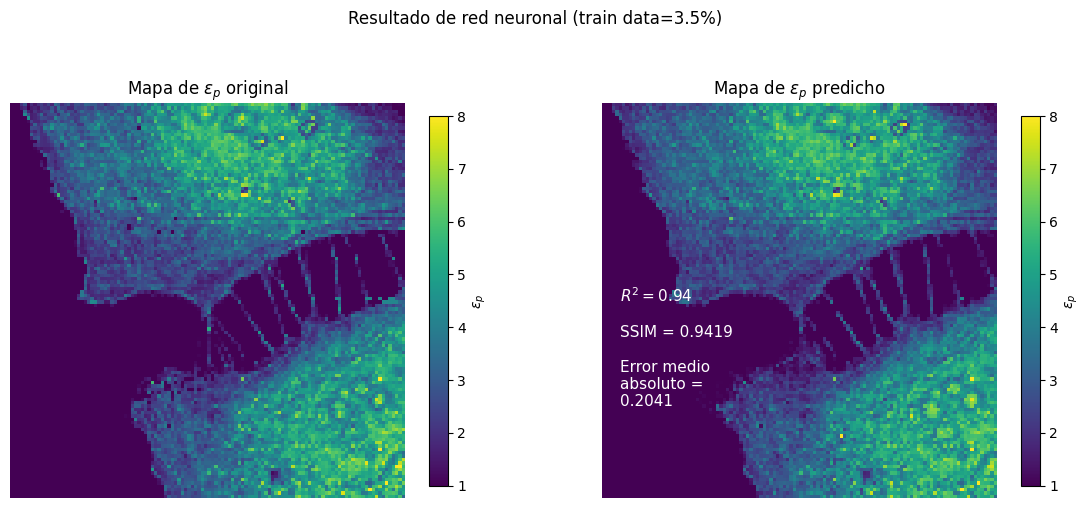

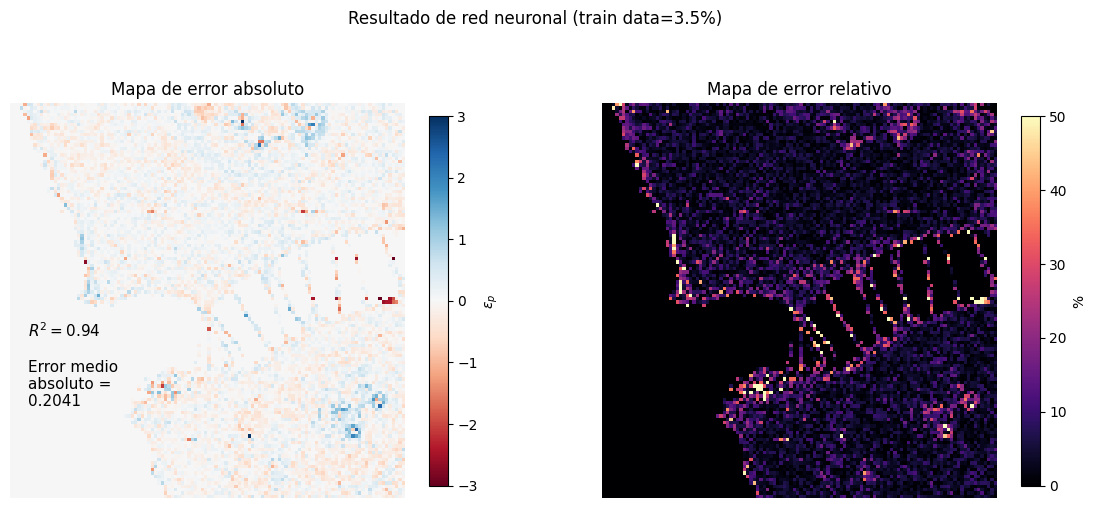

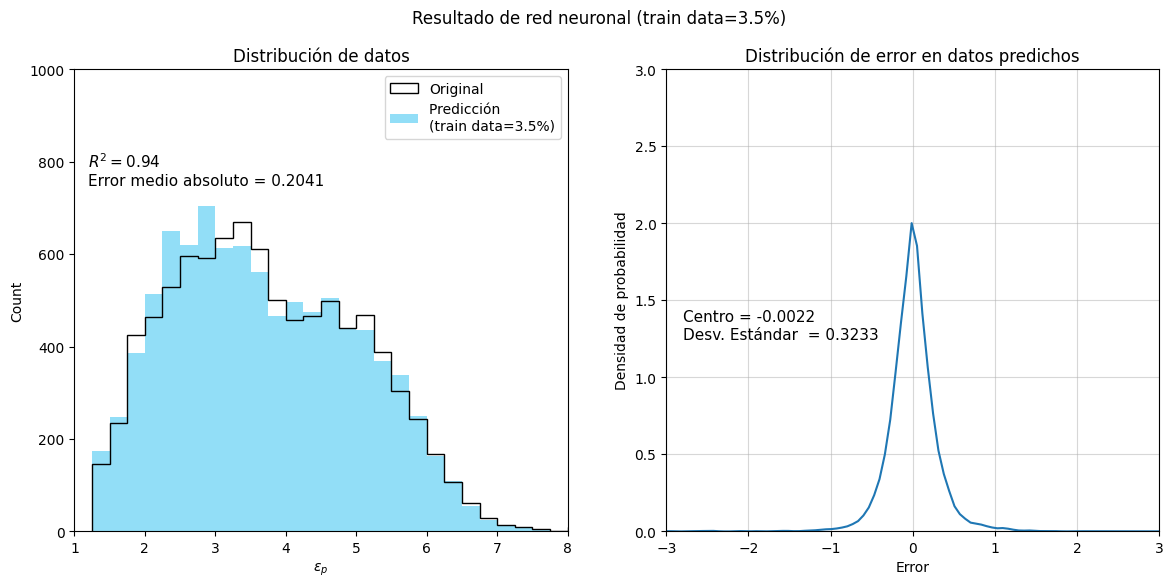

<Figure size 640x480 with 0 Axes>

In [14]:
full_vec_roi=np.zeros(nu_dim**2)+1
for i in np.arange(len(roi_index)):
    full_vec_roi[roi_index[i]]=res[i]



for i in y.index[np.array(cell_index)[train_index]]:
    full_vec_roi[i]=y.iloc[i]

full_img_roi=np.reshape(full_vec_roi,(nu_dim,nu_dim))
full_vec_roi=pd.DataFrame(full_vec_roi)
full_roi=copy(full_vec_roi)
full_cell=pd.DataFrame(full_roi.iloc[roi_index])

#Metrics calculations
res_cell=np.array(full_vec_roi.iloc[cell_index])
full_vec_cell=np.zeros(nu_dim**2)+1
for i in np.arange(len(cell_index)):
    full_vec_cell[cell_index[i]]=res_cell[i]
full_img_cell=np.reshape(full_vec_cell,(nu_dim,nu_dim))

error_map=np.subtract(full_img_cell,y_mat)
error_map_r=(abs(np.subtract(y_mat, full_img_cell))/y_mat)*100

ssim = np.round(ssim(y_mat, full_img_cell, data_range=full_img_cell.max() - full_img_cell.min()), decimals=4)
print(ssim)

rsqr_cell=np.round(r2_score(y_cell, res_cell), decimals=4)
mae_cell=mean_absolute_error(y_cell, res_cell)


fig1=plt.figure(figsize=(14,6))

ax=fig1.add_subplot(1,2,1)
pcm=ax.imshow(y_mat, vmin=1, vmax=8)
ax.axis("off")
plt.colorbar(pcm, shrink=0.8, label="$ε_{p}$")
ax.set_title("Mapa de $ε_p$ original")


ax=fig1.add_subplot(1,2,2)
pcm=ax.imshow(full_img_roi, vmin=1, vmax=8)
ax.axis("off")
plt.colorbar(pcm, shrink=0.8, label="$ε_{p}$")
ax.set_title("Mapa de $ε_p$ predicho")
ax.text(5, 90, "$R^2 = $"+str(rsqr_cell)+"\n\nSSIM = "+str(ssim)+"\n\nError medio\nabsoluto = \n"+str(np.round(mae_cell, decimals=4)), fontsize=11, color="#fff")

fig1.suptitle("Resultado de red neuronal (train data="+str(pctg)+"%)")

fig2=plt.figure(figsize=(14,6))

ax=fig2.add_subplot(1,2,1)
pcm=ax.imshow(error_map, cmap="RdBu", vmin=-3, vmax=3)
ax.set_title("Mapa de error absoluto")
ax.axis("off")
plt.colorbar(pcm, shrink=0.8, label="$ε_p$")
ax.text(5, 90, "$R^2 = $"+str(rsqr_cell)+"\n\nError medio\nabsoluto = \n"+str(np.round(mae_cell, decimals=4)), fontsize=11, color="#000")

ax=fig2.add_subplot(1,2,2)
pcm=ax.imshow(error_map_r, cmap="magma", vmin=0, vmax=50)
ax.set_title("Mapa de error relativo")
ax.axis("off")
plt.colorbar(pcm, shrink=0.8, label="%")


fig2.suptitle("Resultado de red neuronal (train data="+str(pctg)+"%)")

fig3=plt.figure(figsize=(14,6))

ax=fig3.add_subplot(1,2,1)
binss=(np.arange(32)*0.25)+1.25
xaxis=(np.arange(9))
ax.hist(y_cell, histtype="step", color="#000",bins=binss)
ax.hist(full_cell, histtype="bar", color="#92def7",bins=binss)
ax.set_xticks(xaxis)
ax.set_xlim([1,8])
ax.set_ylim([0,1000])
ax.set_title("Distribución de datos")
ax.legend(["Original","Predicción \n(train data="+str(pctg)+"%)"])
ax.set_xlabel("$ε_{p}$")
ax.set_ylabel("Count")
ax.text(1.2, 750, "$R^2 = $"+str(rsqr_cell)+"\nError medio absoluto = "+str(np.round(mae_cell, decimals=4)), fontsize=11, color="#000")



thresh=1
print("The error map presents "+str(len(error_map[abs(error_map)>thresh]))+" error values > "+str(thresh)+" ("+str(np.round((len(error_map[abs(error_map)>thresh])/len(y_cell))*100, decimals=2))+"%)")
plt.figure()
err=pd.DataFrame(np.subtract(res_cell,y_cell))
ax=fig3.add_subplot(1,2,2)
ax = sns.kdeplot(data=err, ax=ax)
legend=ax.legend()
legend.remove()
ax.set_title("Distribución de error en datos predichos")
ax.set_xlabel("Error")
ax.set_ylabel("Densidad de probabilidad")
ax.set_xlim((-3,3))
ax.set_ylim((0,3))
ax.grid('on', alpha=0.5)
err_mean, err_std=norm.fit(err)
ax.text(-2.8, 1.25, "Centro = "+str(np.round(err_mean, decimals=4))+"\nDesv. Estándar  = "+str(np.round(err_std, decimals=4)), fontsize=11, color="#000")

fig3.suptitle("Resultado de red neuronal (train data="+str(pctg)+"%)")


In [15]:
export=0

filename=rf'{name}'
folder=rf'd:\Exports\pres240510'



if export:
    img_export(filename, folder, full_img_roi, full_cell, topography_file, nu_dim)
    histogram_export(full_cell, filename, folder)


export_ref=0

filename=rf'{name}_sim'
folder=rf'd:\Exports\pres240510'

if export_ref: 
    img_export(filename, folder, y_mat, y_cell, topography_file, nu_dim)
    histogram_export(y_cell, filename, folder)
